In [85]:
import torch

def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

def integ_func(x, y):
  "Returns interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
    Y = torch.zeros_like(y)
    Y[1:] = (x[1:]-x[:-1])*(
        (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
        )
    Y = Y.cumsum(0)
  def f(xs):
    if len(y)==1:
      return y[0]*(xs - x[0])
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = H_poly((xs-x[I])/dx)
    return Y[I] + dx*(
        hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
        )
  return f

def integ(x, y, xs):
  return integ_func(x,y)(xs)

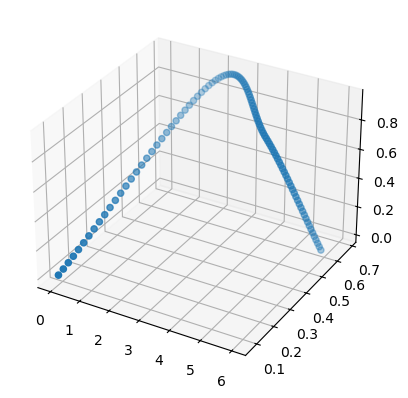

In [86]:
import matplotlib.pyplot as plt # for plotting
x = torch.linspace(0, 6, 4)
y = torch.rand(4)
z = torch.rand(4)
u = torch.linspace(0, 1, 4)
us = torch.linspace(0, 1, 101)
xs = interp(u, x, us)
ys = interp(u, y, us)
zs = interp(u, z, us)
xyzs = torch.stack((xs, ys, zs))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs, ys, zs)

In [87]:
x_con = torch.rand(4).requires_grad_(True)
y_con = torch.rand(4).requires_grad_(True)
z_con = torch.rand(4).requires_grad_(True)
u_con = torch.linspace(0, 1, 4)
us_con = torch.linspace(0, 1, 101)

In [88]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [89]:
optimizer = torch.optim.Adam([x_con, y_con, z_con], lr=0.01)

In [90]:
x_con.min().detach().numpy()

array(0.07854813, dtype=float32)

In [91]:
loss_array = []
pre_loss = 100
for i in range(1000):
    x_pre = interp(u_con, x_con, us_con)
    y_pre = interp(u_con, y_con, us_con)
    z_pre = interp(u_con, z_con, us_con)
    xyz_pre = torch.stack((x_pre, y_pre, z_pre))
    loss = loss_fn(xyzs, xyz_pre)
    loss.backward()
    print(z_con.grad)
    optimizer.step()
    optimizer.zero_grad()
    if abs(loss.detach() - pre_loss) < 0.0001:
        loss_array.append(loss.detach())
        break
    pre_loss = loss.detach()
    loss_array.append(pre_loss)

tensor([ 0.1118, -0.3774, -0.0842,  0.2514])
tensor([ 0.1100, -0.3697, -0.0756,  0.2500])
tensor([ 0.1082, -0.3620, -0.0670,  0.2486])
tensor([ 0.1063, -0.3543, -0.0585,  0.2472])
tensor([ 0.1045, -0.3465, -0.0500,  0.2457])
tensor([ 0.1026, -0.3387, -0.0416,  0.2442])
tensor([ 0.1008, -0.3310, -0.0334,  0.2426])
tensor([ 0.0989, -0.3232, -0.0253,  0.2410])
tensor([ 0.0971, -0.3154, -0.0176,  0.2394])
tensor([ 0.0952, -0.3077, -0.0103,  0.2376])
tensor([ 0.0934, -0.3001, -0.0035,  0.2358])
tensor([ 0.0916, -0.2925,  0.0028,  0.2338])
tensor([ 0.0898, -0.2850,  0.0083,  0.2317])
tensor([ 0.0880, -0.2776,  0.0132,  0.2295])
tensor([ 0.0863, -0.2704,  0.0172,  0.2272])
tensor([ 0.0846, -0.2632,  0.0204,  0.2247])
tensor([ 0.0829, -0.2562,  0.0228,  0.2220])
tensor([ 0.0812, -0.2494,  0.0244,  0.2192])
tensor([ 0.0796, -0.2427,  0.0251,  0.2162])
tensor([ 0.0780, -0.2361,  0.0251,  0.2132])
tensor([ 0.0764, -0.2296,  0.0245,  0.2100])
tensor([ 0.0748, -0.2233,  0.0232,  0.2067])
tensor([ 0

Text(0, 0.5, 'loss')

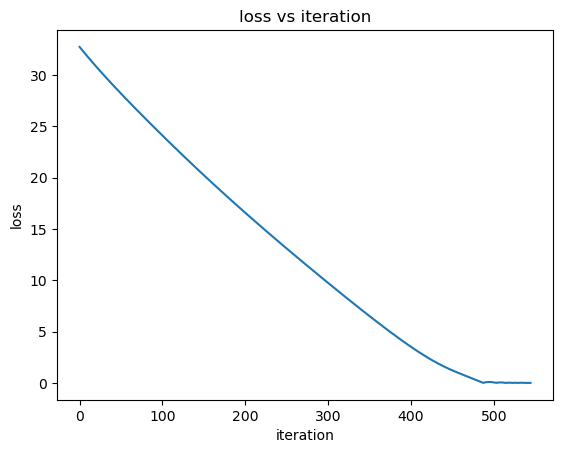

In [92]:
plt.plot(loss_array)
plt.title('loss vs iteration')
plt.xlabel('iteration')
plt.ylabel('loss')

In [93]:
y_con

tensor([0.0794, 0.6520, 0.5930, 0.5762], requires_grad=True)

In [94]:
x_con

tensor([-4.7856e-04,  2.0000e+00,  3.9992e+00,  6.0022e+00],
       requires_grad=True)

In [95]:
z_con

tensor([0.0134, 0.9028, 0.6717, 0.0243], requires_grad=True)

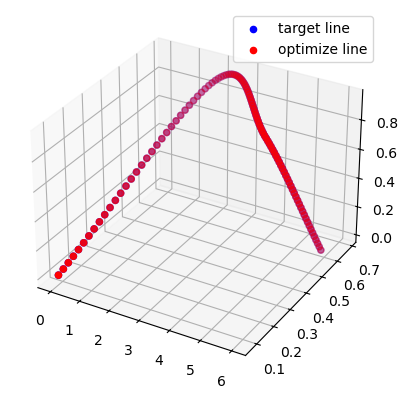

In [96]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c='b', label='target line')
ax.scatter(x_pre.detach(), y_pre.detach(), z_pre.detach(), c='r', label='optimize line')
ax.legend()
